<a href="https://colab.research.google.com/github/twelvesense/first-repository/blob/master/ExplNode14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트 : CIFAR-10 이미지 생성하기

# 1: 기본 작업 환경

## 1.1: module 및 data 준비

In [ ]:
import os
import glob
import time
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import mediapy as media
from IPython.display import Image, display

In [ ]:
!pip install -q mediapy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
colab_dir = '/content/drive/MyDrive/colab/ExplNode14'

cifar10_dir = colab_dir + '/data/cifar10'

Mounted at /content/drive


# 2: 데이터셋 준비

In [ ]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

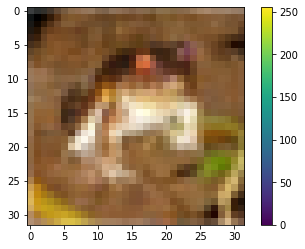

In [ ]:
plt.imshow(train_x[0])
plt.colorbar()

In [ ]:
# 픽셀값 범위 확인
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [ ]:
# 픽셀값 정규화: -1 ~ 1
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [ ]:
train_x[0].shape

(32, 32, 3)

In [ ]:
train_x[0]

array([[[-0.5372549 , -0.51372549, -0.50588235],
        [-0.6627451 , -0.63921569, -0.64705882],
        [-0.60784314, -0.62352941, -0.6627451 ],
        ...,
        [ 0.23921569,  0.03529412, -0.15294118],
        [ 0.19215686, -0.01960784, -0.2       ],
        [ 0.16078431, -0.02745098, -0.19215686]],

       [[-0.8745098 , -0.84313725, -0.84313725],
        [-1.        , -1.        , -1.        ],
        [-0.85882353, -0.9372549 , -1.        ],
        ...,
        [-0.03529412, -0.30980392, -0.56862745],
        [-0.06666667, -0.34901961, -0.60784314],
        [-0.04313725, -0.31764706, -0.55294118]],

       [[-0.80392157, -0.81176471, -0.83529412],
        [-0.8745098 , -0.94509804, -1.        ],
        [-0.61568627, -0.78823529, -0.9372549 ],
        ...,
        [-0.0745098 , -0.34117647, -0.60784314],
        [-0.05882353, -0.34117647, -0.60784314],
        [-0.14509804, -0.42745098, -0.67058824]],

       ...,

       [[ 0.63137255,  0.33333333, -0.24705882],
        [ 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


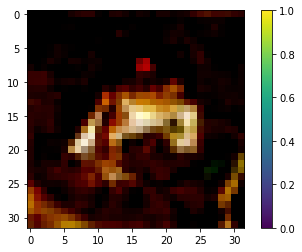

In [ ]:
# 첫번쨰 데이터 확인
plt.imshow(train_x[0])
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

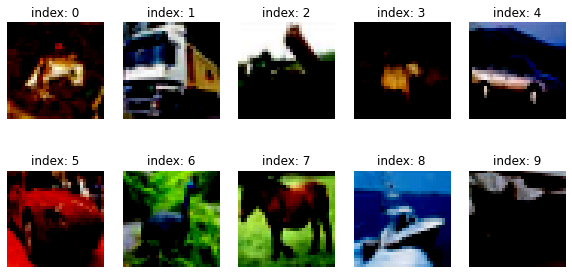

In [ ]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')

In [ ]:
# 텐서플로우의 Dataset이용한 미니배치
BUFFER_SIZE = 50000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 3: 생성자 모델 구현하기

In [ ]:
def make_generator_model():
    
    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [ ]:
# 생성 모델을 generator라는 변수로 생성
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

In [ ]:
# tf.random.normal을 이용하면 가우시안 분포에서 뽑아낸 노이즈 벡터
noise = tf.random.normal([1, 100])
# 랜덤이미지
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


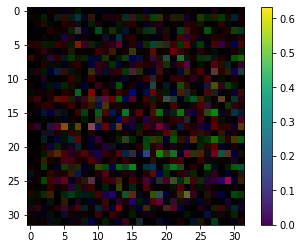

In [ ]:
plt.imshow(generated_image[0]*10)
plt.colorbar()

In [ ]:
generated_image[0]

<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
array([[[ 0.00145037, -0.000925  , -0.00018756],
        [ 0.00264969, -0.00710768, -0.00763846],
        [-0.00269418, -0.00017076,  0.00621546],
        ...,
        [ 0.00680835, -0.00226632, -0.0023433 ],
        [-0.00254568, -0.00021223, -0.00198857],
        [ 0.00629773, -0.00257689,  0.00282713]],

       [[ 0.00071388,  0.0036187 , -0.00275809],
        [-0.00336784,  0.00305143, -0.0093236 ],
        [ 0.00229156,  0.01149194, -0.00768507],
        ...,
        [ 0.0050457 ,  0.00625768, -0.00224649],
        [-0.01470229,  0.01215449,  0.01798214],
        [ 0.009607  , -0.00311353,  0.00416548]],

       [[-0.00614871, -0.0038618 , -0.00285454],
        [ 0.0082541 , -0.01318503, -0.00104434],
        [ 0.01123351,  0.00516658, -0.01019506],
        ...,
        [-0.00908289,  0.00316381, -0.00615364],
        [ 0.00050556, -0.00608245, -0.00140178],
        [ 0.0047299 , -0.00458013, -0.01148155]],

       ...,

       

#4: 판별자 모델 구현하기

In [ ]:
def make_discriminator_model():
    
    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
# discriminator생성
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [ ]:
# 랜덤이미지에 대한 판별자 결과
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00226644]], dtype=float32)>

#5: 손실함수와 최적화 함수 구현하기

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

#6: 훈련과정 상세 기능 구현하기

In [ ]:
# 샘플은 한 번에 16장 생성
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [ ]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')
   
    plt.savefig(cifar10_dir + '/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))
    plt.show()

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6  

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig(cifar10_dir + '/training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()


In [ ]:
checkpoint_dir = cifar10_dir + '/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#7: 학습 과정 진행하기

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
train_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float64, name=None)>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

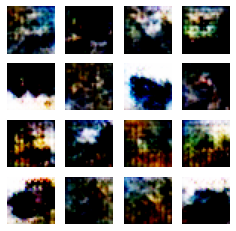

Time for training : 499 sec


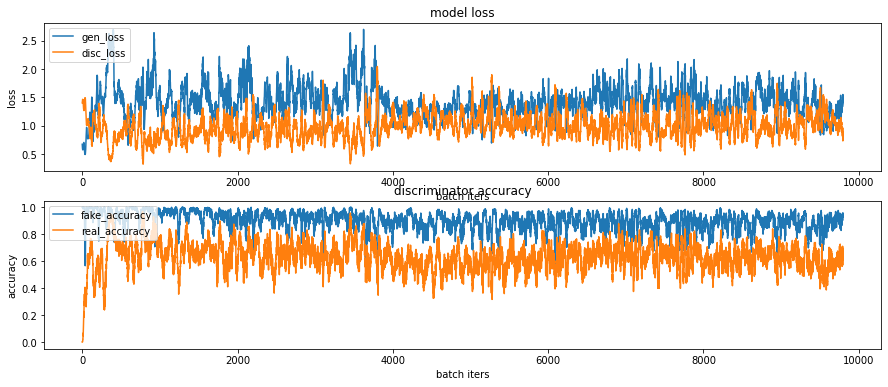

In [ ]:
save_every = 5
EPOCHS = 50
train(train_dataset, EPOCHS, save_every)

In [ ]:
anim_file = cifar10_dir + '/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(cifar10_dir + '/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
!ls -l '/content/drive/MyDrive/colab/ExplNode14/data/cifar10/cifar10_dcgan.gif'

-rw------- 1 root root 1111936 Jun 23 23:15 /content/drive/MyDrive/colab/ExplNode14/data/cifar10/cifar10_dcgan.gif


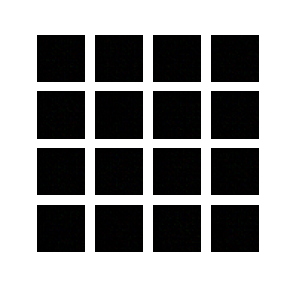

In [ ]:
# # checkpoint  모듈을  활용하여  모델을  로드하는  예시
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# checkpoint.restore(latest)

# generator = checkpoint.generator
# discriminator = checkpoint.discriminator

# # 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
# noise = tf.random.normal([1, 100])
# generated_image = generator(noise, training=False)

# np_generated = generated_image.numpy()
# np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
# np_generated = np_generated.astype(int)
# plt.imshow(np_generated[0])
# plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [ ]:
# 로드된 모델의 파라미터 상태에서 훈련을 재개
# %%time 
# train(train_dataset,  EPOCHS,  save_every) 

#8: GAN 훈련 과정 개선하기: WGAN-GP 이용

* 현존 최고라고 하는 WGAN-GP를 따라해본다.<br>
  https://keras.io/examples/generative/wgan_gp/

##8.1: 생성자 구현

In [ ]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 3, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    # At this point, we have an output which has the same shape as the input, (32, 32, 1).
    # We will use a Cropping2D layer to make it (28, 28, 1).
    # x = layers.Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_8 (Dense)             (None, 4096)              409600    
                                                                 
 batch_normalization_15 (Bat  (None, 4096)             16384     
 chNormalization)                                                
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_4 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d_9 (UpSampling  (None, 8, 8, 256)        0         
 2D)                                                     

##8.2:판별자 구현

In [ ]:
IMG_SHAPE = (32, 32, 3)
def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x

def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    # Zero pad the input to make the input images size to (32, 32, 1).
    # x = layers.ZeroPadding2D((2, 2))(img_input)                       # 수정
    x = img_input
    x = conv_block(
        x,                                                            
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_8 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 4, 4, 256)       

##8.3: 모델 구현

In [ ]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))

##8.4: 학습 과정 구현

In [ ]:
train_images = train_x

In [ ]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for trainining.
epochs = 20

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training the model.
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

Epoch 1/20
196/196 [==============================] - 67s 315ms/step - d_loss: -5.1736 - g_loss: 15.0816
Epoch 2/20
196/196 [==============================] - 62s 314ms/step - d_loss: -3.3735 - g_loss: 6.5137
Epoch 3/20
196/196 [==============================] - 62s 314ms/step - d_loss: -3.0767 - g_loss: 1.8097
Epoch 4/20
196/196 [==============================] - 62s 314ms/step - d_loss: -2.7949 - g_loss: -1.3533
Epoch 5/20
196/196 [==============================] - 62s 314ms/step - d_loss: -2.7314 - g_loss: -3.1859
Epoch 6/20
196/196 [==============================] - 62s 314ms/step - d_loss: -2.4873 - g_loss: -6.2747
Epoch 7/20
196/196 [==============================] - 61s 313ms/step - d_loss: -2.2582 - g_loss: -4.6454
Epoch 8/20
196/196 [==============================] - 61s 313ms/step - d_loss: -2.1316 - g_loss: -2.9829
Epoch 9/20
196/196 [==============================] - 61s 313ms/step - d_loss: -1.9630 - g_loss: -6.3927
Epoch 10/20
196/196 [==============================] - 61

##8.5: 결과

###■ 3개 이미지의 생성 결과

1번째 생성 이미지 결과


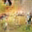

2번째 생성 이미지 결과


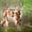

3번째 생성 이미지 결과


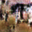

In [ ]:
print('1번째 생성 이미지 결과')
display(Image("/content/drive/MyDrive/colab/ExplNode14/data/generated_img_0_19.png", width=60))
print('2번째 생성 이미지 결과')
display(Image("/content/drive/MyDrive/colab/ExplNode14/data/generated_img_1_19.png", width=60))
print('3번째 생성 이미지 결과')
display(Image("/content/drive/MyDrive/colab/ExplNode14/data/generated_img_2_19.png", width=60))

###■ 3개 이미지의 생성 과정 (animated gif)

1번째 생성 이미지 과정 (gif)


""

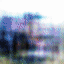

2번째 생성 이미지 과정 (gif)


""

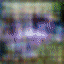

3번째 생성 이미지 과정 (gif)


""

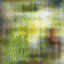

In [ ]:
video1 = media.read_video("/content/drive/MyDrive/colab/ExplNode14/data/generated_img_0_ani.gif")
video1 = media.resize_video(video1, np.array(video1.shape[1:3]) * 2)
print('1번째 생성 이미지 과정 (gif)')
media.show_video(video1, fps=3, codec='gif')
video2 = media.read_video("/content/drive/MyDrive/colab/ExplNode14/data/generated_img_1_ani.gif")
video2 = media.resize_video(video2, np.array(video2.shape[1:3]) * 2)
print('2번째 생성 이미지 과정 (gif)')
media.show_video(video2, fps=3, codec='gif')
video3 = media.read_video("/content/drive/MyDrive/colab/ExplNode14/data/generated_img_2_ani.gif")
video3 = media.resize_video(video3, np.array(video3.shape[1:3]) * 2)
print('3번째 생성 이미지 과정 (gif)')
media.show_video(video3, fps=3, codec='gif')

#9: 회고

* DCGAN모델을 통해서 이미지를 생성할 수 있었다.
* gif를 통해 생성이미지 품질의 향상과 학습그래프에서의 fake accuracy의 올바른 변화를 확인할 수 있었다.
* 개선모델인 Wasserstein GAN-GP를 알게 되고, 이를 통해서 개선됨을 확인할 수 있었다.
> GAN의 문제점으로는 <br>
. 기울기 손실로 인한 학습의 어러움이 있고, <br>
. 생성 성능를 손실함수로부터 판별하기 어렵다.<br>
> 이를 개선한 Wasserstein GAN 모델은 <br>
. Wasserstein거리에 의한 손실함수인 Wasserstein loss를 적용하고<br>
. Grgdient penality개념를 도입한 discriminator를 사용한다.